In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt

Diffusion occurs in a wide variety of materials during processing.  For example, diffusion is used to dope semiconductors to fabricate devices.  This process is called diffusion doping.  The example below illustrates how a diode can be fabricated through this process. 

A $7~\mathrm{\mu m}$ thick B-doped (p-type) Si wafer is annealed at $950~\mathrm{{}^\circ C}$ while in equilibrium with a gas containing P vapor (donor).  The concentration of B in the wafer is $2\times 10^{17} / \mathrm{cm^3}$.  P diffusivity in this system at this condition is $D\approx 10^{-14}~\mathrm{cm^2/s}$.  Assume that the concentration of P at the surface in this case is $10^{21}/\mathrm{cm^3}$.  To fabricate a device with a junction at approximately $1~\mathrm{\mu m}$ from the surface, one would like to match the P and B concentrations at a depth of $1~\mathrm{\mu m}$.  

NOTE: 
 - Distances are in micrometers
 - Diffusion coefficient DP is in $\mathrm{\mu m}^2/s$
 - Times are in seconds

In [3]:
DP = 1.0e-6 # Diffusion coefficient (mum^2 / s)
cP = 1.0e9  # Surface concentration of phosphorus (mum^-3)
cB = 2.0e5  # Bulk concentration of boron (mum^-3)

OutputDist = 1.0    # Distance at which we will output concentration (mum)
ThickM  = 7.0       # thickness of wafer (mum)

### (a)

Using the following analytical formula determine how much time it will take for the concentration of P at a distance $x = 1~\mathrm{\mu m}$ from the surface to be equal to the concentration of B. 

$$C(x,t) = C_\text{surface}\left[1 - \mathrm{erf}\left(\frac{x}{2\sqrt{D t}}\right)\right]$$

Note that the $\mathrm{erf}$ function can be evaluated using SciPy (you can also consider using the complementary error function, $\mathrm{erfc}$, which is one minus the error function).

In [4]:
from scipy.special import erf
from numpy import sqrt

In [5]:
def analyticalConcentration(t, x):
    return cP * (1 - erf(x / (2 * sqrt(DP * t))))

## graphical solution

In [6]:
from numpy import linspace

In [7]:
t = linspace(0, 1e6, 100)

/Users/guyer/anaconda/envs/fipy-b/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


<IPython.core.display.Javascript object>


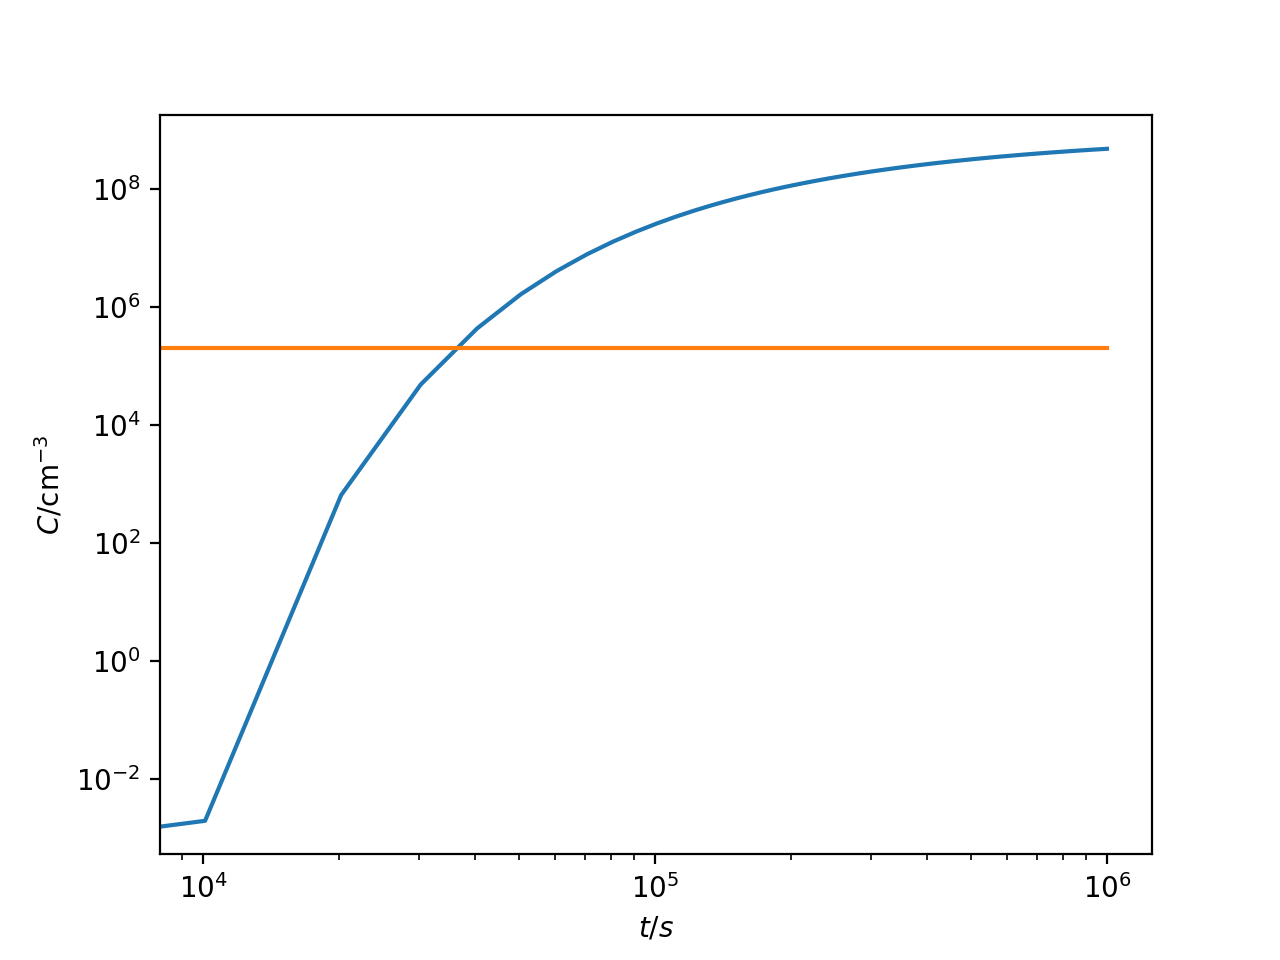

Text(0,0.5,'$C / \\mathrm{cm}^{-3}$')

In [8]:
plt.loglog(t, analyticalConcentration(t, OutputDist))
plt.loglog([0., 1e6], [cB, cB])
plt.xlabel("$t / s$")
plt.ylabel(r"$C / \mathrm{cm}^{-3}$")

## numerical solution

In [9]:
from scipy.optimize import fsolve

In [11]:
finalTime = fsolve(lambda t, x: analyticalConcentration(t, x) - cB, x0=1e5, args=(OutputDist))[0]
finalTime

36150.4574601705

## FiPy solution

In [12]:
import fipy as fp
from IPython.display import display, clear_output

In [32]:
gridThickM = 1.0e-2 # grid size (mum)
nx = int(ThickM/gridThickM) # number of grid points perpendicular to surface
dt = 1000.0         # Time step (s)

<IPython.core.display.Javascript object>


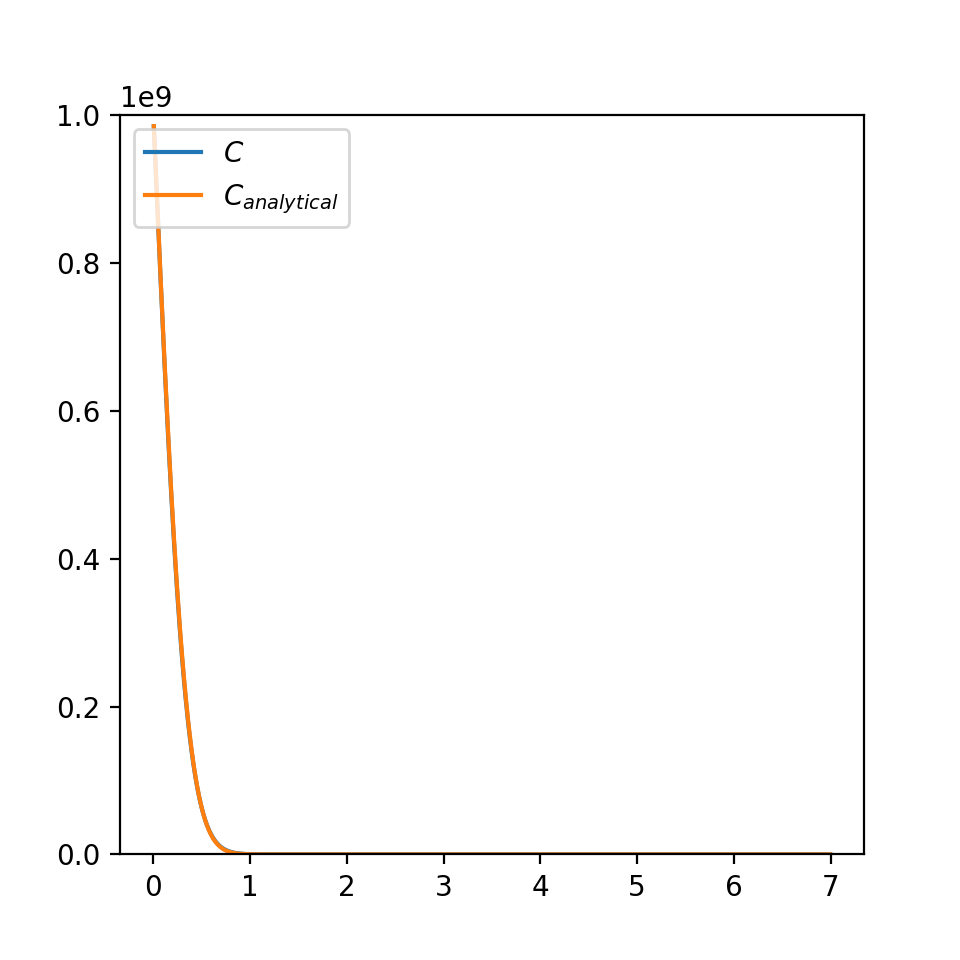

In [33]:
mesh = fp.Grid1D(dx=gridThickM, nx=nx)

C = fp.CellVariable(mesh=mesh, name="$C$", value=0.0, hasOld=True)
Canalytical = fp.CellVariable(mesh=mesh, name="$C_{analytical}$")

x, = mesh.cellCenters
Canalytical.setValue(analyticalConcentration(t=finalTime, x=x))

viewer = fp.MatplotlibViewer(vars=(C, Canalytical), datamin=1e-9, datamax=cP)
viewer.plot()

C.constrain(cP, where=mesh.facesLeft)

## CORE OF THE CODE IS THE NEXT EQUATION
eq1 = fp.TransientTerm() == fp.DiffusionTerm(DP)

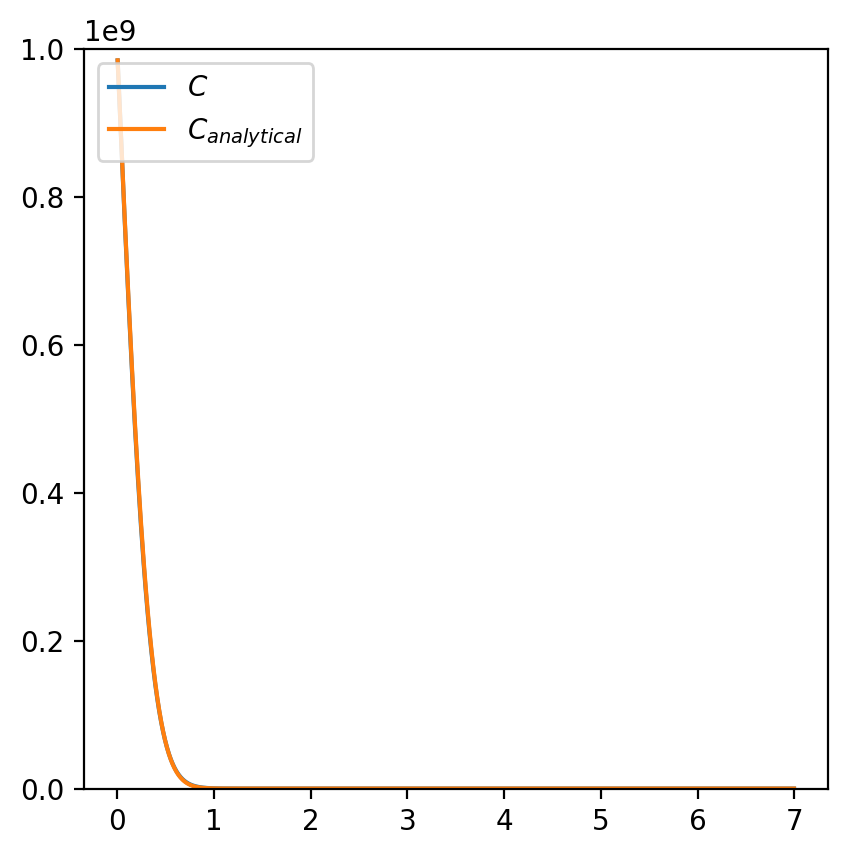

In [34]:
results = []
t = 0
while t <= finalTime:
    t=t+dt
    C.updateOld()
    eq1.solve(C, dt=dt)
    if t % 1800 == 0:
        results.append([t, C([[OutputDist]],order=1)[0]])
        # In a plain Python script, we would write
        #   viewer.plot()
        # but that doesn't work in a Jupyter notebook
        clear_output(wait=True)
        display(viewer)

<IPython.core.display.Javascript object>


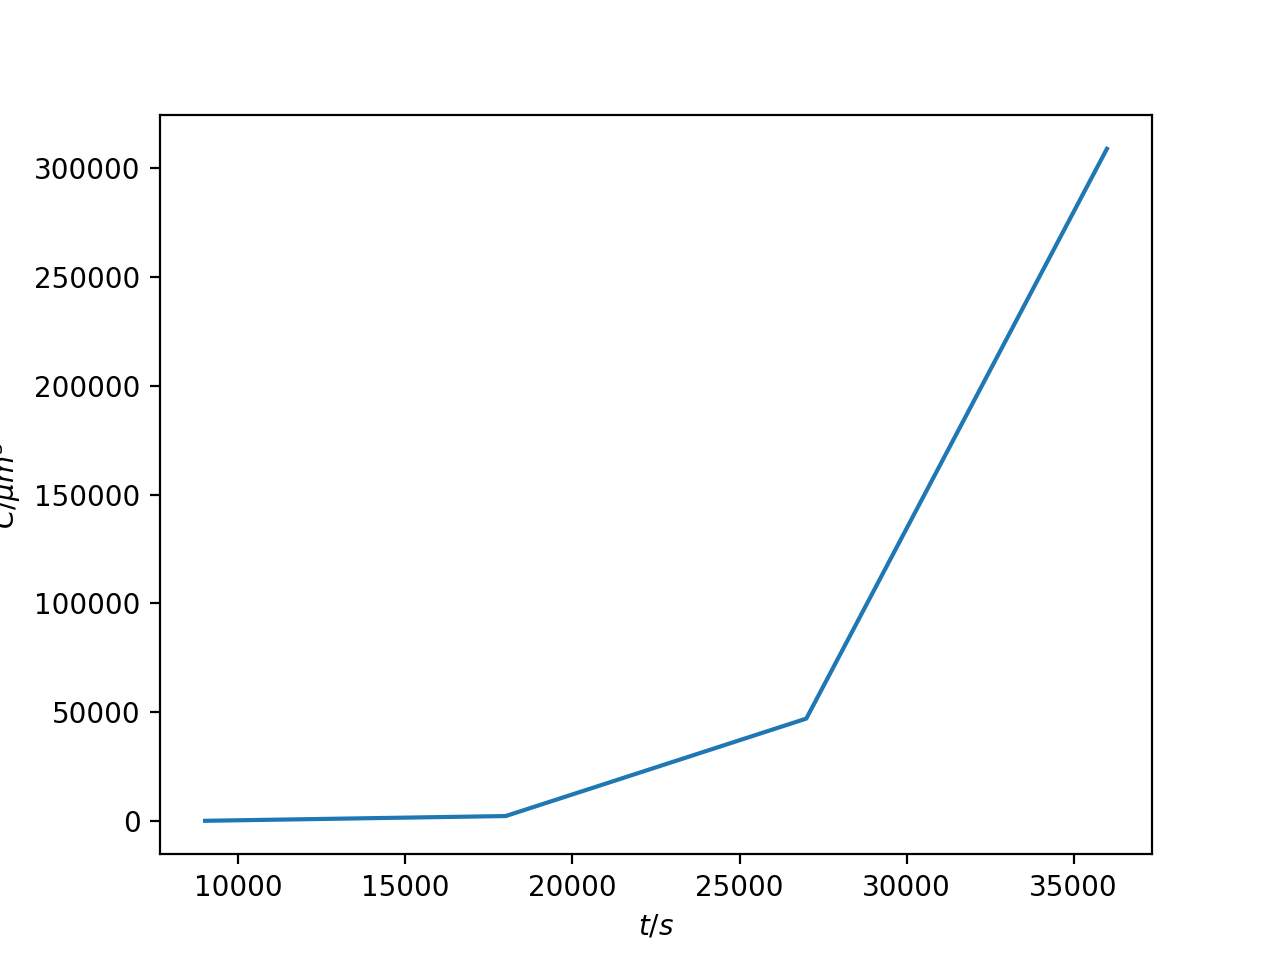

Text(0,0.5,'$C / \\mu m^3$')

In [35]:
results = fp.numerix.array(results)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(results[..., 0], results[..., 1])
ax.set_xlabel("$t / s$")
ax.set_ylabel(r"$C / \mu m^3$")

### (b)

What time step is needed for the numerical solution to agree with the analytical solution.  For this part of the problem set, use the 1D diffusion simulation script provided above.  Try time steps of (2, 20, 200, and 2000) s.  For a time of 10 hours and a distance of 1 μm, what value of time step gives agreement with the analytical solution to within one percent?

### (c)

The error function solution given above assumes an infinitely thick domain.  Since your sample has finite thickness, this solution will not be accurate for your finite-sized sample beyond some time.  To appreciate the effect, modify the code so that your sample is 1.02 micrometer thick.  Compute the concentration at a depth of 1.02 micrometers after 10 hours (using the converged time step from part (b)) and compare with the analytical solution.

### (d)

What do you do if you want to reduce the time required for annealing?  What “knob” would you control in your processing equipment?

![](img/schematic2D.png)